## Part 1: Supervised Baseline (Feedforward Network)
**Project**: FraudGuard - Credit Card Fraud Detection 

**Goal**: Establish a strong supervised benchmark using Weighted Loss and Threshold Optimization.

## 1. Setup and Exploratory Data Analysis (EDA)
**Objective**: Understand the data distribution and justify preprocessing decisions.

Using device: cpu
Dataset Loaded. Shape: (284807, 31)


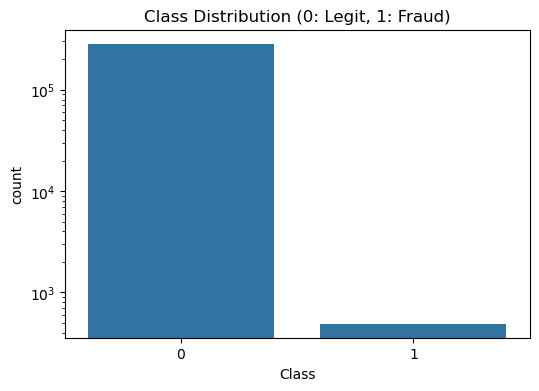

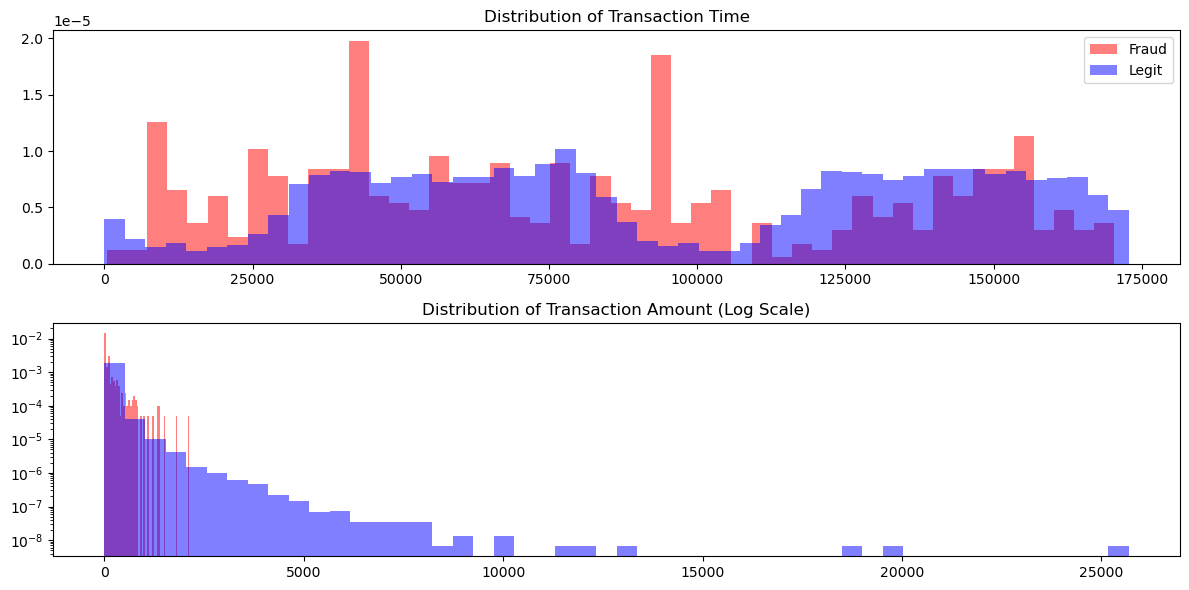

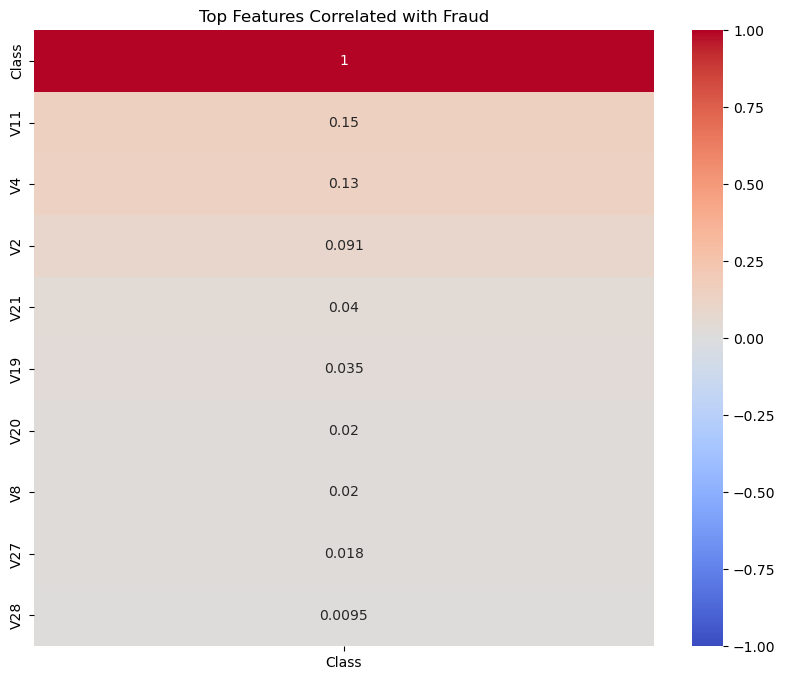

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Load Data ---
try:
    df = pd.read_csv('creditcard.csv')
    print(f"Dataset Loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found.")

# --- 2. EDA: Class Imbalance ---
# Rationale: Visualizing the <0.2% fraud rate to justify Weighted Loss.
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Legit, 1: Fraud)')
plt.yscale('log') # Log scale is crucial here
plt.show()

# --- 3. EDA: Feature Distributions ---
# Rationale: Checking if 'Time' and 'Amount' need scaling.
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(12, 6))
bins = 50

ax1.hist(df.Time[df.Class == 1], bins=bins, color='red', alpha=0.5, density=True, label='Fraud')
ax1.hist(df.Time[df.Class == 0], bins=bins, color='blue', alpha=0.5, density=True, label='Legit')
ax1.set_title('Distribution of Transaction Time')
ax1.legend()

ax2.hist(df.Amount[df.Class == 1], bins=bins, color='red', alpha=0.5, density=True, label='Fraud')
ax2.hist(df.Amount[df.Class == 0], bins=bins, color='blue', alpha=0.5, density=True, label='Legit')
ax2.set_title('Distribution of Transaction Amount (Log Scale)')
ax2.set_yscale('log')
plt.tight_layout()
plt.show()

# --- 4. EDA: Correlation ---
# Rationale: Identifying top predictors among PCA features.
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr[['Class']].sort_values(by='Class', ascending=False).head(10), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top Features Correlated with Fraud')
plt.show()

## 2. Preprocessing & Data Pipeline
**Objective**: Scale features, split data, and create PyTorch Loaders.

In [2]:
# --- 1. Feature Scaling ---
# Based on EDA, Time and Amount have very different ranges than V1-V28.
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# --- 2. Stratified Split ---
# Stratify is required to keep the fraud ratio consistent in Train/Val.
X = df.drop('Class', axis=1).values
y = df['Class'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3. PyTorch Dataset & Loaders ---
class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64
train_dataset = FraudDataset(X_train, y_train)
val_dataset = FraudDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Data Pipeline Ready.")

Data Pipeline Ready.


## 3. Model A: Basic Baseline
**Objective**: Establish initial performance with a standard FCN.

In [9]:
# ==========================================
# 3. Model A: Basic Baseline (Explicit Training)
# ==========================================

# --- Architecture ---
class FraudFCN(nn.Module):
    def __init__(self, input_dim):
        super(FraudFCN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- Setup ---
input_dim = X_train.shape[1]
model_basic = FraudFCN(input_dim).to(device)

# Calculate Weight for Imbalance
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
pos_weight = torch.tensor([num_neg / num_pos], device=device)
print(f"Using Positive Class Weight: {pos_weight.item():.2f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_basic.parameters(), lr=0.001)

# --- Training Loop (Basic) ---
EPOCHS = 10
print("\n--- Training Basic Model ---")

for epoch in range(EPOCHS):
    # 1. Training Phase
    model_basic.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_basic(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    # 2. Validation Phase
    model_basic.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_basic(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# --- Evaluation (Basic) ---
print("\n--- Basic Model Results (Threshold 0.5) ---")
model_basic.eval()
y_true = []
y_pred_basic = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        logits = model_basic(inputs)
        probs = torch.sigmoid(logits)
        y_true.extend(labels.cpu().numpy())
        y_pred_basic.extend((probs > 0.5).float().cpu().numpy())

print(classification_report(y_true, y_pred_basic, target_names=['Legit', 'Fraud']))


Using Positive Class Weight: 577.29

--- Training Basic Model ---
Epoch [1/10] Train Loss: 0.5550 | Val Loss: 0.2951
Epoch [2/10] Train Loss: 0.3204 | Val Loss: 0.3095
Epoch [3/10] Train Loss: 0.2950 | Val Loss: 0.3144
Epoch [4/10] Train Loss: 0.2905 | Val Loss: 0.3125
Epoch [5/10] Train Loss: 0.2565 | Val Loss: 0.3405
Epoch [6/10] Train Loss: 0.2267 | Val Loss: 0.3615
Epoch [7/10] Train Loss: 0.2653 | Val Loss: 0.3074
Epoch [8/10] Train Loss: 0.2168 | Val Loss: 0.3009
Epoch [9/10] Train Loss: 0.1993 | Val Loss: 0.4089
Epoch [10/10] Train Loss: 0.2064 | Val Loss: 0.4750

--- Basic Model Results (Threshold 0.5) ---
              precision    recall  f1-score   support

       Legit       1.00      0.98      0.99     56864
       Fraud       0.08      0.91      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962



## 4. Model B: Improved Architecture
**Objective**: Improve stability using Batch Normalization.

In [ ]:
# ==========================================
# 4. Model B: Improved Architecture (Explicit Training)
# ==========================================

# --- Architecture ---
class ImprovedFraudFCN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedFraudFCN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),  # Stabilizes learning
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),  # Stabilizes learning
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- Setup ---
model_improved = ImprovedFraudFCN(input_dim).to(device)
optimizer = optim.Adam(model_improved.parameters(), lr=0.001)
# We reuse 'criterion' (same weights)

# --- Training Loop (Improved + Early Stopping) ---
EPOCHS = 10
best_val_loss = float('inf')
patience = 5
trigger_times = 0

print("\n--- Training Improved Model ---")

for epoch in range(EPOCHS):
    # 1. Training Phase
    model_improved.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_improved(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    # 2. Validation Phase
    model_improved.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_improved(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # 3. Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model_improved.state_dict(), 'improved_model.pth')
        trigger_times = 0 # Reset counter
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at Epoch {epoch+1}!")
            break

# --- Evaluation (Improved) ---
print("\n--- Improved Model Results (Threshold 0.5) ---")
# Load the best version saved during training
model_improved.load_state_dict(torch.load('improved_model.pth'))
model_improved.eval()
y_true = []
y_pred_improved = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        logits = model_improved(inputs)
        probs = torch.sigmoid(logits)
        y_true.extend(labels.cpu().numpy())
        y_pred_improved.extend((probs > 0.5).float().cpu().numpy())

print(classification_report(y_true, y_pred_improved, target_names=['Legit', 'Fraud']))


--- Training Improved Model ---
Epoch [1/10] Train Loss: 0.4849 | Val Loss: 0.3421
Epoch [2/10] Train Loss: 0.3478 | Val Loss: 0.2883
Epoch [3/10] Train Loss: 0.3145 | Val Loss: 0.2870
Epoch [4/10] Train Loss: 0.3002 | Val Loss: 0.2921
Epoch [5/10] Train Loss: 0.2564 | Val Loss: 0.2902
Epoch [6/10] Train Loss: 0.2962 | Val Loss: 0.2873
Epoch [7/10] Train Loss: 0.2660 | Val Loss: 0.2789
Epoch [8/10] Train Loss: 0.2655 | Val Loss: 0.2894
Epoch [9/10] Train Loss: 0.2242 | Val Loss: 0.3223
Epoch [10/10] Train Loss: 0.2360 | Val Loss: 0.2805

--- Improved Model Results (Threshold 0.5) ---
              precision    recall  f1-score   support

       Legit       1.00      0.96      0.98     56864
       Fraud       0.04      0.93      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.95      0.53     56962
weighted avg       1.00      0.96      0.98     56962



## 5. Evaluation & Comparison (Threshold Moving)
**Objective**: Compare models and optimize the decision threshold for the best model.

Optimal Threshold: 0.9979
Best F1 Score: 0.8041

--- Final Results (Basic) ---
ROC-AUC: 0.9834
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56864
       Fraud       0.81      0.79      0.80        98

    accuracy                           1.00     56962
   macro avg       0.91      0.89      0.90     56962
weighted avg       1.00      1.00      1.00     56962



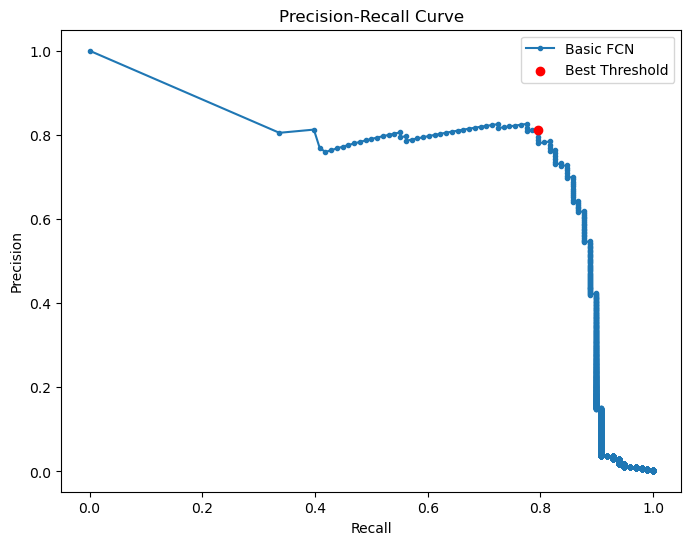

In [18]:
# --- 1. Get Probabilities from Basic Model ---
model_basic.eval()
y_true = []
y_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        logits = model_basic(inputs)
        probs = torch.sigmoid(logits)
        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# --- 2. Threshold Optimization ---
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_idx]:.4f}")

# --- 3. Final Evaluation ---
y_pred_basic = (np.array(y_probs) > best_threshold).astype(int)
roc_auc = roc_auc_score(y_true, y_probs)

print(f"\n--- Final Results (Basic) ---")
print(f"ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_true, y_pred_basic, target_names=['Legit', 'Fraud']))

# --- 4. Visualization: Precision-Recall Curve ---
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Basic FCN')
plt.scatter(recall[best_idx], precision[best_idx], marker='o', color='red', label='Best Threshold', zorder=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Optimal Threshold: 0.9969
Best F1 Score: 0.8351

--- Final Results (Improved + Optimized) ---
ROC-AUC: 0.9876
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56864
       Fraud       0.84      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



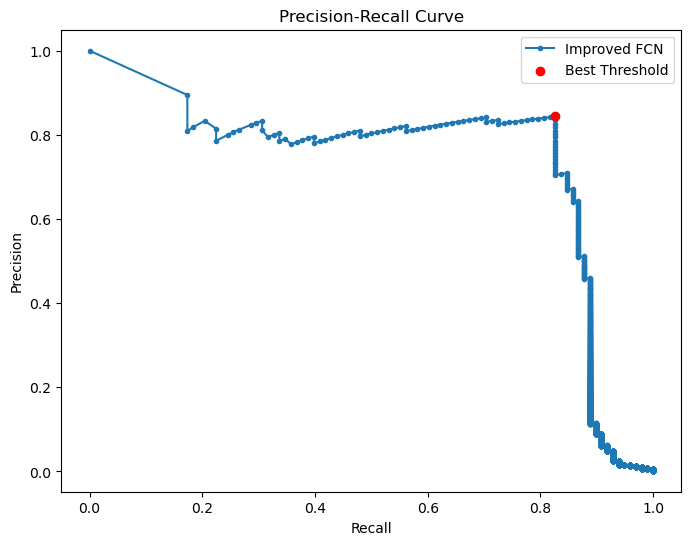

In [19]:
# --- 1. Get Probabilities from Improved Model ---
model_improved.eval()
y_true = []
y_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        logits = model_improved(inputs)
        probs = torch.sigmoid(logits)
        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# --- 2. Threshold Optimization ---
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_idx]:.4f}")

# --- 3. Final Evaluation ---
y_pred_opt = (np.array(y_probs) > best_threshold).astype(int)
roc_auc = roc_auc_score(y_true, y_probs)

print(f"\n--- Final Results (Improved + Optimized) ---")
print(f"ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_true, y_pred_opt, target_names=['Legit', 'Fraud']))

# --- 4. Visualization: Precision-Recall Curve ---
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Improved FCN')
plt.scatter(recall[best_idx], precision[best_idx], marker='o', color='red', label='Best Threshold', zorder=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## 6. Final Visualization: Confusion Matrix
**Objective**: Visualize the cost of False Positives.

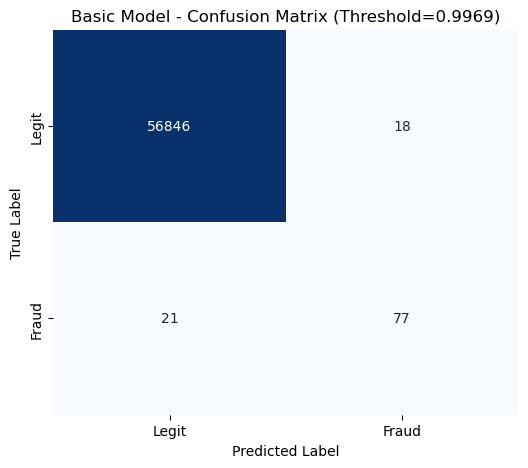

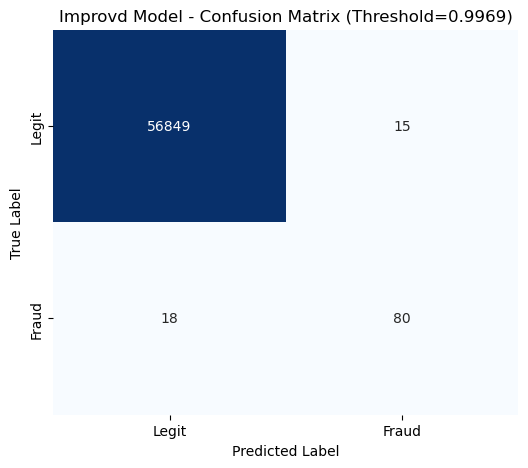

In [20]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    
    # Heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Legit', 'Fraud'], 
                yticklabels=['Legit', 'Fraud'])
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Run for the Optimized Predictions
plot_confusion_matrix(y_true, y_pred_basic, title=f"Basic Model - Confusion Matrix (Threshold={best_threshold:.4f})")
plot_confusion_matrix(y_true, y_pred_opt, title=f"Improvd Model - Confusion Matrix (Threshold={best_threshold:.4f})")